In [1]:
try:
    from transformers import BertModel, BertTokenizer
except:
    !pip install transformers
    from transformers import BertModel, BertTokenizer
import pandas as pd
import numpy as np

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA, SparsePCA, MiniBatchSparsePCA, IncrementalPCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

import datetime
import pickle
import os
import tqdm
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings(action='ignore')
from transformers import logging
logging.set_verbosity_error()

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device='cpu'
print('Using device:', device)

Using device: cuda:0


In [4]:
class BertEmbedding(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        res = []
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        Bert = BertModel.from_pretrained('bert-base-uncased')
        Bert.requires_grad_(False)
        self.Bert = Bert.to(device)
        for i in tqdm.tqdm(range(X.shape[0])):
            res.append(self.token_pretrain(X['Tweet'].iloc[i]))
        res = np.array(res)
        res = res.reshape([res.shape[0], -1])
        #         with open(f'./embedding{datetime.now()}.pkl', 'wb') as file:
        #             pickle.dump(res, file)
        return res
    
    def token_pretrain(self, text):
        btc_token = self.tokenizer(str(text), 
                                   padding='max_length', 
                                   truncation = True, 
                                   max_length=100, 
                                   return_tensors='pt').to(device)
        return self.Bert(input_ids=btc_token['input_ids'], 
                       attention_mask=btc_token['attention_mask'])[0].detach().cpu().numpy()[0] 

In [5]:
def preprocess_pipe(n_components=1000):
    return Pipeline([
        ('Embedding', BertEmbedding()),
        ('pca', IncrementalPCA(n_components=n_components, batch_size=2000))
    ], verbose=True)


#('pca', PCA(n_components=n_components))
#MiniBatchSparsePCA(n_components=5, batch_size=50, random_state=0)
#IncrementalPCA(n_components=7, batch_size=200)

In [6]:
def classifier_pipe(classifier, name, preprocess_pipe):
    return Pipeline([
        ('Preprocess', preprocess_pipe),
        (name, classifier)
    ], verbose=True)

In [7]:
class GenerateTrainTest:
    def __init__(self, df):
        self.df = df
    
    @staticmethod
    def ColSelector(df: pd.DataFrame, series=None, toker_list=None):
        cols = df.columns
        res = []
        if series and toker_list:
            res = [x for x in cols if x.split('-')[0] in toker_list and x.split('-')[1] in series]
        elif series:
            res = [x for x in cols if x.split('-')[1] in series]
        elif toker_list:
            res = [x for x in cols if x.split('-')[0] in toker_list]
        return res    
    
    def train_test(self, y_name, test_size=0.1):
        # X = self.df.drop(columns=['BTC-close', 'BTC-open', 'BTC-high', 'BTC-low']).shift(1).iloc[1:, :]
        X = self.df.shift(1).iloc[1:, :]
        Y = (self.df[[y_name]].iloc[1:, :] > 0).astype(int)
        return train_test_split(X, Y, test_size = test_size, shuffle=False)

In [8]:
class Pipelines:
    def __init__(self, pipeline):
        self.pipe = pipeline
        self.hyperparameter = dict()
        
    def timeseries_cv(self, X_train, Y_train, n_fold=5):
        cv = TimeSeriesSplit(n_splits=n_fold)
        return cross_val_score(self.pipe, X_train, Y_train, cv=cv, verbose=False)
    
    def fit_train(self, X_train, Y_train):
        self.pipe.fit(X_train, Y_train)
        return self.pipe.predict(X_train)
    
    def predict_test(self, X_test):
        return self.pipe.predict(X_test)
    
    def hyperparameter_tuning(self):
        pass    

# Bitcoin

In [9]:
dt_model = DecisionTreeClassifier(class_weight="balanced", max_depth=500, random_state=1024)
dt_pipe = classifier_pipe(dt_model, 'DecisionTree', preprocess_pipe())
dt_pipe

Pipeline(steps=[('Preprocess',
                 Pipeline(steps=[('Embedding', BertEmbedding()),
                                 ('pca',
                                  IncrementalPCA(batch_size=2000,
                                                 n_components=1000))],
                          verbose=True)),
                ('DecisionTree',
                 DecisionTreeClassifier(class_weight='balanced', max_depth=500,
                                        random_state=1024))],
         verbose=True)

In [10]:
btc_all = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/Decision_Tree_NLP/btc_all.csv', index_col='Date')
btc_all.index = pd.to_datetime(btc_all.index).tz_localize('UTC')
price_vol = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/Decision_Tree_NLP/price_vol_filledNa.csv', index_col=0)[['BTC-close']]
price_vol.index = pd.to_datetime(price_vol.index)
price_vol.shape

(17501, 1)

In [11]:
btc_all.head()

,Tweet
Date,
2020-09-26 00:00:00+00:00,I dunno sat at this Bitcoin price doesnt look...
2020-09-26 02:00:00+00:00,Markaccy reached its highest price on Septembe...
2020-09-26 04:00:00+00:00,bitcoin will finish the monthly candle above k...
2020-09-26 06:00:00+00:00,An asset that is humanmade and starts at a pri...
2020-09-26 07:00:00+00:00,The strength of BAND that can resist the price...


In [12]:
price_vol

,BTC-close
2020-09-26 00:00:00+00:00,0.002983
2020-09-26 01:00:00+00:00,0.002983
2020-09-26 02:00:00+00:00,0.001411
2020-09-26 03:00:00+00:00,0.000122
2020-09-26 04:00:00+00:00,0.001383
...,...
2022-09-25 00:00:00+00:00,0.001259
2022-09-25 01:00:00+00:00,0.000494
2022-09-25 02:00:00+00:00,-0.000934
2022-09-25 03:00:00+00:00,0.004757


In [13]:
btc_all = pd.merge(price_vol, btc_all, how='left', left_index=True, right_index=True)
btc_all['Tweet'].isna().value_counts()

False    17151
True       350
Name: Tweet, dtype: int64

In [14]:
btc_all.head()

,BTC-close,Tweet
2020-09-26 00:00:00+00:00,0.002983,I dunno sat at this Bitcoin price doesnt look...
2020-09-26 01:00:00+00:00,0.002983,monero price showing a little positive action ...
2020-09-26 02:00:00+00:00,0.001411,Markaccy reached its highest price on Septembe...
2020-09-26 03:00:00+00:00,0.000122,NaN
2020-09-26 04:00:00+00:00,0.001383,bitcoin will finish the monthly candle above k...


In [15]:
btc_all.fillna(method='ffill', inplace=True)
btc_all.head()

,BTC-close,Tweet
2020-09-26 00:00:00+00:00,0.002983,I dunno sat at this Bitcoin price doesnt look...
2020-09-26 01:00:00+00:00,0.002983,monero price showing a little positive action ...
2020-09-26 02:00:00+00:00,0.001411,Markaccy reached its highest price on Septembe...
2020-09-26 03:00:00+00:00,0.000122,Markaccy reached its highest price on Septembe...
2020-09-26 04:00:00+00:00,0.001383,bitcoin will finish the monthly candle above k...


In [16]:
gtt = GenerateTrainTest(btc_all)
X_train_all, X_test, Y_train_all, Y_test = gtt.train_test("BTC-close", test_size=0.2)

In [17]:
X_train_all.shape, X_test.shape, Y_train_all.shape, Y_test.shape

((14000, 2), (3500, 2), (14000, 1), (3500, 1))

In [18]:
pipe = Pipelines(dt_pipe)
# cv_score = pipe.timeseries_cv(X_train_all, Y_train_all)
# f"Cross validation score: {(sum(cv_score) / len(cv_score)).round(4)}"

In [19]:
pipe.pipe.fit(X_train_all, Y_train_all)
del X_train_all, Y_train_all
Y_hat = pipe.predict_test(X_test)
f"Accuracy in test set: {accuracy_score(Y_test, Y_hat).round(4)}"

100%|██████████| 14000/14000 [04:01<00:00, 57.86it/s]


[Pipeline] ......... (step 1 of 2) Processing Embedding, total= 4.1min
[Pipeline] ............... (step 2 of 2) Processing pca, total= 5.8min
[Pipeline] ........ (step 1 of 2) Processing Preprocess, total=10.0min
[Pipeline] ...... (step 2 of 2) Processing DecisionTree, total=  26.7s


100%|██████████| 3500/3500 [01:02<00:00, 56.20it/s]


'Accuracy in test set: 0.4983'

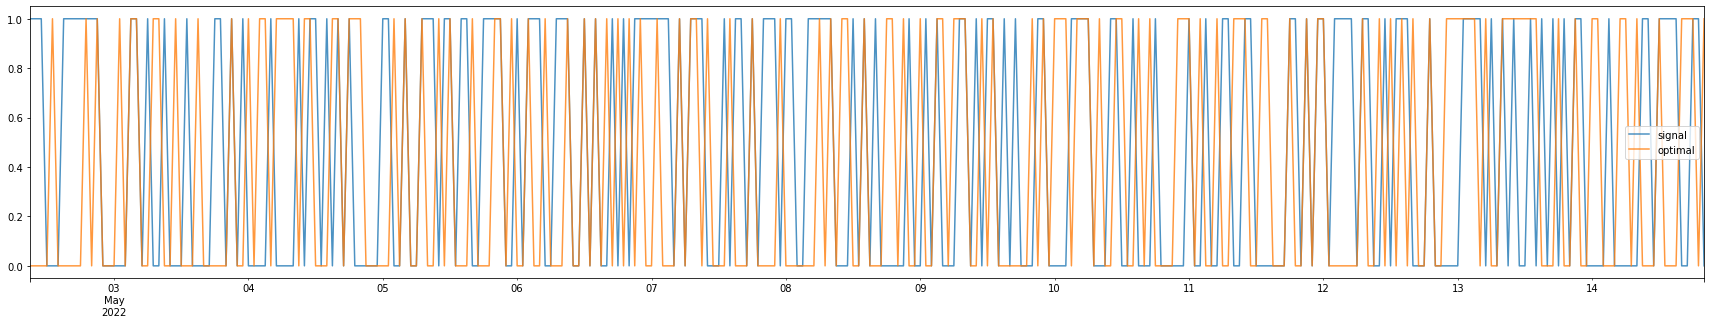

In [20]:
result_logistic = gtt.df[['BTC-close']].iloc[-len(Y_hat):, :]
result_logistic['real'] = (1 + result_logistic['BTC-close']).cumprod()
result_logistic['signal'] = Y_hat.astype(float)
result_logistic['strat'] = (1 + result_logistic['BTC-close'] * result_logistic['signal']).cumprod()
result_logistic['optimal'] = (result_logistic['BTC-close'] > 0).astype(float)
result_logistic[:300][['signal', 'optimal']].plot(figsize=(30, 5), alpha=0.8)

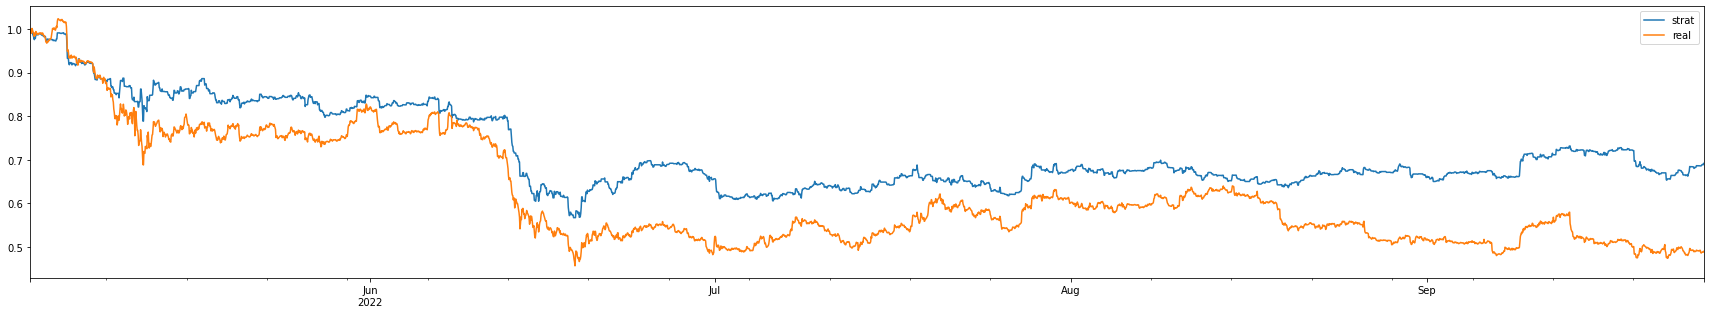

In [21]:
result_logistic[['strat', 'real']].plot(figsize=(30, 5))

# ETH

In [22]:
dt_model = DecisionTreeClassifier(class_weight="balanced", max_depth=500, random_state=1024)
dt_pipe = classifier_pipe(dt_model, 'DecisionTree', preprocess_pipe())
dt_pipe

Pipeline(steps=[('Preprocess',
                 Pipeline(steps=[('Embedding', BertEmbedding()),
                                 ('pca',
                                  IncrementalPCA(batch_size=2000,
                                                 n_components=1000))],
                          verbose=True)),
                ('DecisionTree',
                 DecisionTreeClassifier(class_weight='balanced', max_depth=500,
                                        random_state=1024))],
         verbose=True)

In [23]:
eth_all = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/Decision_Tree_NLP/eth_all.csv', index_col='Date')
eth_all.index = pd.to_datetime(eth_all.index).tz_localize('UTC')
price_vol = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/Decision_Tree_NLP/price_vol_filledNa.csv', index_col=0)[['ETH-close']]
price_vol.index = pd.to_datetime(price_vol.index)

In [24]:
eth_all.tail(), eth_all.shape

(                                                                       Tweet
 Date                                                                        
 2022-09-24 19:00:00+00:00  Well I dont see the Bitcoin and the Crypto mar...
 2022-09-24 20:00:00+00:00  Cardano price unmoved by Vasil upgrade despite...
 2022-09-24 21:00:00+00:00  Bitcoin Cash prediction as price eyes breakout...
 2022-09-24 22:00:00+00:00  Do you guys know the reason crypto never exper...
 2022-09-24 23:00:00+00:00  Bottom is getting close cause Im wanting to ge...,
 (14102, 1))

In [25]:
price_vol.tail(), price_vol.shape

(                           ETH-close
 2022-09-25 00:00:00+00:00   0.001680
 2022-09-25 01:00:00+00:00   0.000542
 2022-09-25 02:00:00+00:00  -0.000359
 2022-09-25 03:00:00+00:00   0.005197
 2022-09-25 04:00:00+00:00   0.000523, (17501, 1))

In [26]:
eth_all = pd.merge(price_vol, eth_all, how='left', left_index=True, right_index=True)
eth_all['Tweet'].isna().value_counts()

False    14102
True      3399
Name: Tweet, dtype: int64

In [27]:
eth_all.head()

,ETH-close,Tweet
2020-09-26 00:00:00+00:00,0.002570,I am a twitter bot using AI to predict price m...
2020-09-26 01:00:00+00:00,0.002570,monero price showing a little positive action ...
2020-09-26 02:00:00+00:00,0.000179,If you dont pay attention to price impact do y...
2020-09-26 03:00:00+00:00,-0.002808,NaN
2020-09-26 04:00:00+00:00,0.002148,NaN


In [28]:
eth_all.fillna(method='ffill', inplace=True)
eth_all.head()

,ETH-close,Tweet
2020-09-26 00:00:00+00:00,0.002570,I am a twitter bot using AI to predict price m...
2020-09-26 01:00:00+00:00,0.002570,monero price showing a little positive action ...
2020-09-26 02:00:00+00:00,0.000179,If you dont pay attention to price impact do y...
2020-09-26 03:00:00+00:00,-0.002808,If you dont pay attention to price impact do y...
2020-09-26 04:00:00+00:00,0.002148,If you dont pay attention to price impact do y...


In [29]:
gtt = GenerateTrainTest(eth_all)
X_train_all, X_test, Y_train_all, Y_test = gtt.train_test("ETH-close", test_size=0.2)

In [30]:
X_train_all.shape, X_test.shape, Y_train_all.shape, Y_test.shape

((14000, 2), (3500, 2), (14000, 1), (3500, 1))

In [31]:
pipe = Pipelines(dt_pipe)
# cv_score = pipe.timeseries_cv(X_train_all, Y_train_all)
# f"Cross validation score: {(sum(cv_score) / len(cv_score)).round(4)}"

In [32]:
pipe.pipe.fit(X_train_all, Y_train_all)
del X_train_all, Y_train_all
Y_hat = pipe.predict_test(X_test)
f"Accuracy in test set: {accuracy_score(Y_test, Y_hat).round(4)}"

100%|██████████| 14000/14000 [03:16<00:00, 71.28it/s]


[Pipeline] ......... (step 1 of 2) Processing Embedding, total= 3.3min
[Pipeline] ............... (step 2 of 2) Processing pca, total= 5.7min
[Pipeline] ........ (step 1 of 2) Processing Preprocess, total= 9.1min
[Pipeline] ...... (step 2 of 2) Processing DecisionTree, total=  27.2s


100%|██████████| 3500/3500 [00:50<00:00, 69.25it/s]


'Accuracy in test set: 0.4954'

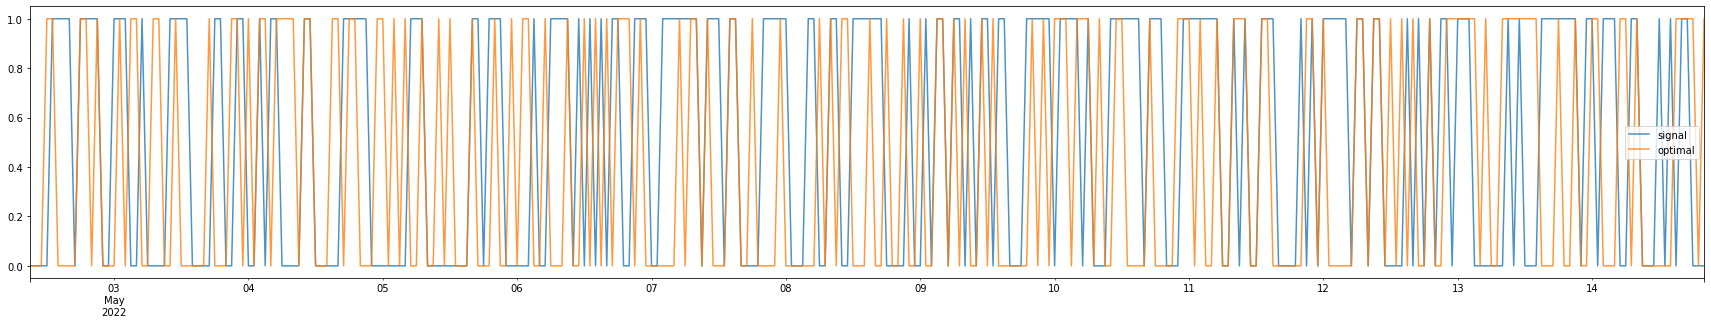

In [33]:
result_logistic = gtt.df[['ETH-close']].iloc[-len(Y_hat):, :]
result_logistic['real'] = (1 + result_logistic['ETH-close']).cumprod()
result_logistic['signal'] = Y_hat.astype(float)
result_logistic['strat'] = (1 + result_logistic['ETH-close'] * result_logistic['signal']).cumprod()
result_logistic['optimal'] = (result_logistic['ETH-close'] > 0).astype(float)
result_logistic[:300][['signal', 'optimal']].plot(figsize=(30, 5), alpha=0.8)

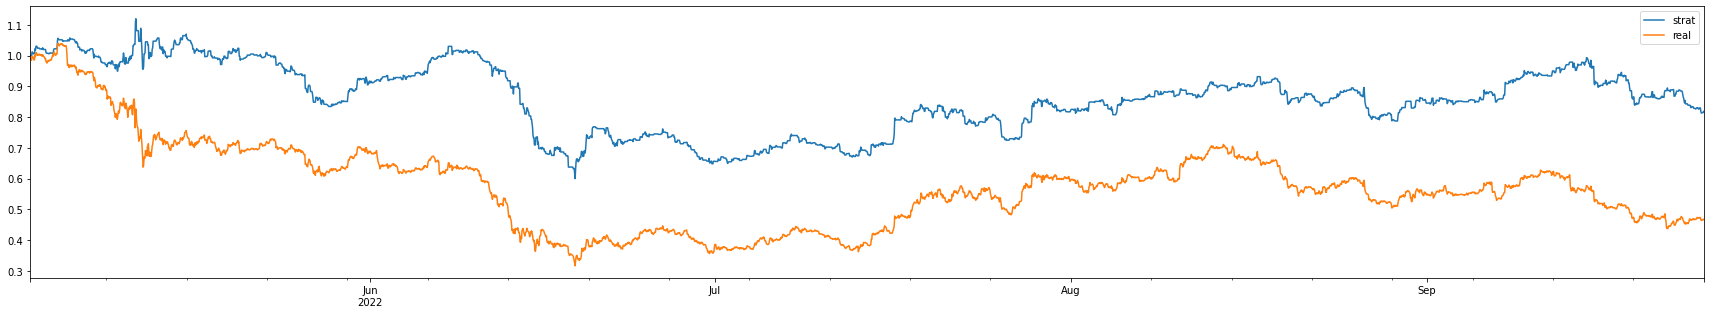

In [34]:
result_logistic[['strat', 'real']].plot(figsize=(30, 5))